## 0. Import modules and run an example of dummy_gym

2024-10-28 14:40:32.243054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 14:40:32.347364: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-10-28 14:40:32.347380: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-28 14:40:32.841505: W tensorflow/compiler/xla/stream_executor/platform/defau

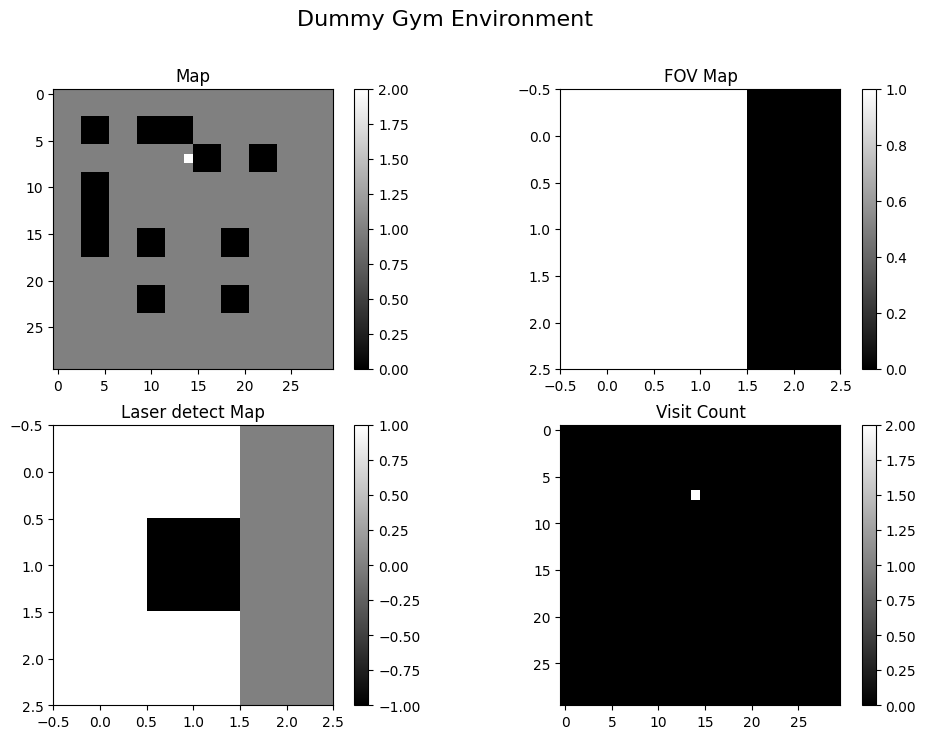

4


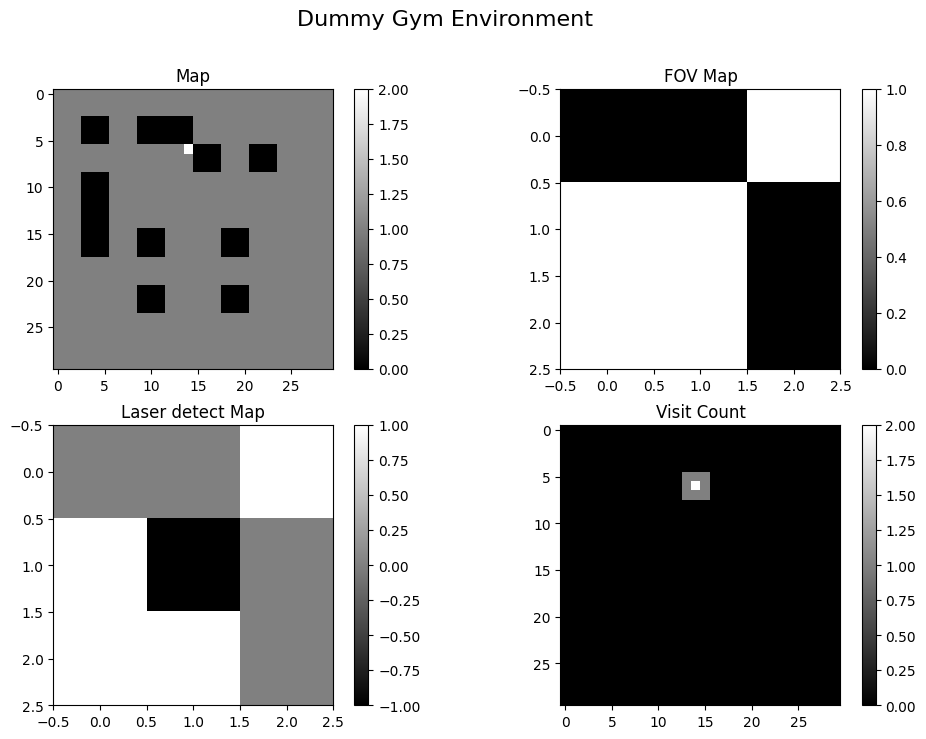

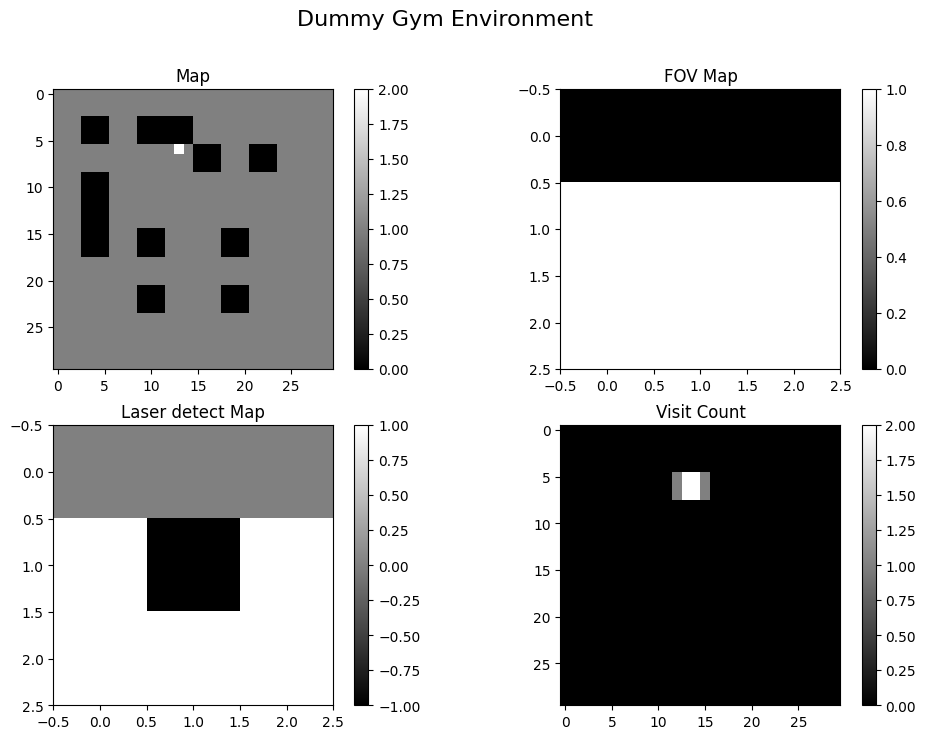

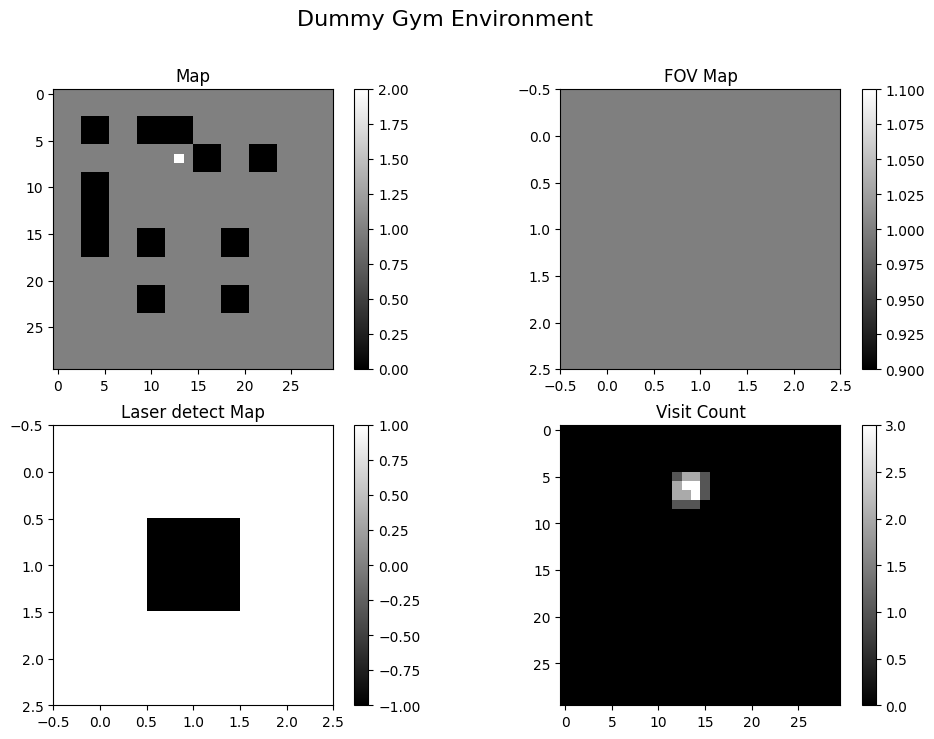

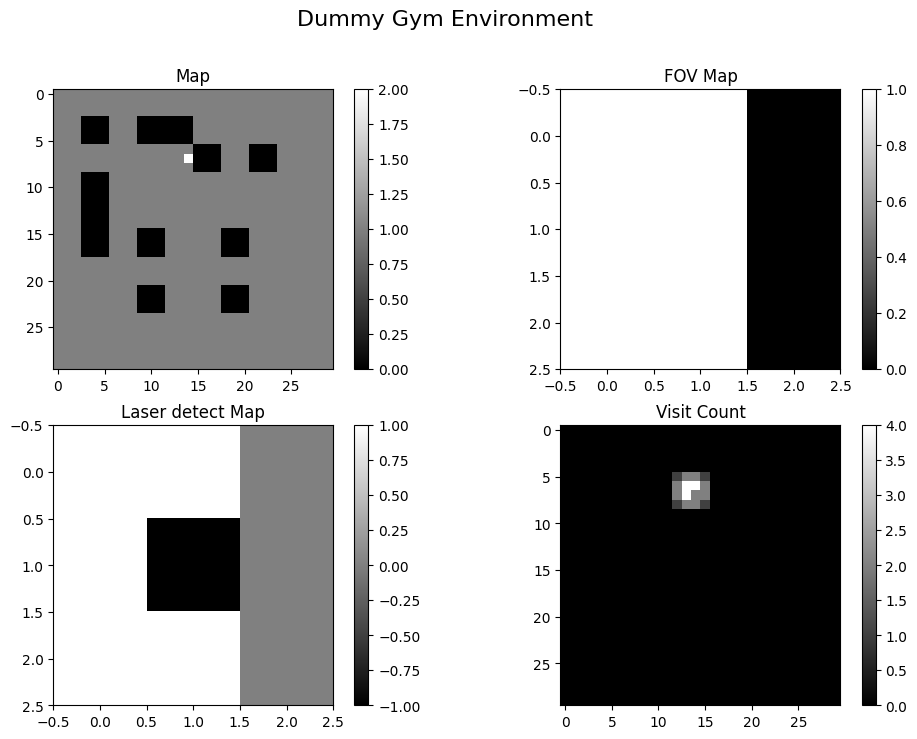

In [1]:
# Import the necessary libraries
import os
os.chdir('/home/zhihan/ME5418')

import gym
import tensorflow as tf
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from dummy_gym import DummyGym
# print(os.getcwd())

# Create the environment instance
env = DummyGym()


## 1. Parameters setting
In order to test our model, we did not assign large parameters

In [2]:
# Hyperparameters
original_state = env.observe()
action_size = env.action_space.n
print(f'action_size is {action_size}')
batch_size = 10 # 每次训练的数据量
n_episodes = 4 # 地图数量
time_steps = 4 # 小车移动次数
epochs = 4 # 每个地图训练次数

# DQN parameters
gamma = 0.99  # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.01 # 最小探索率
epsilon_decay = 0.995 # 探索衰减率

# Replay buffer
replay_buffer = deque(maxlen=2000) # 用于存储训练数据


action_size is 4


## 2. Processing states
The state we get from dummy_gym are lists and have only 2 dimensions. So we have to
1. Use `np.array` to change the type of state to `ndarray` for future data processing
2. Use `map.reshape((*map.shape, 1))` to reshape the state to 3 dimensions

In [3]:
# 处理原始state
def prepare_state(original_state):
    visit_count, fov_map, car_pos = original_state
    visit_count, fov_map, car_pos = np.array(visit_count), np.array(fov_map), np.array(car_pos)

    # add channel dimension
    visit_count_state = visit_count.reshape((*visit_count.shape, 1))
    fov_map_state = fov_map.reshape((*fov_map.shape, 1))
    car_pos_state = car_pos.reshape((*car_pos.shape, 1))
    
    return [visit_count_state, fov_map_state, car_pos_state], [visit_count_state.shape, fov_map_state.shape, car_pos_state.shape]
_, state_shape = prepare_state(original_state)
# print(state_shape[0], state_shape[1], state_shape[2])

## 3. Designing out model
After comparing different model output, we found that model behaves best when follows these settings:
1. `pool=True`
2. `dropout=True`
3. `residual=True`
4. `batch_norm=True`
5. `regularizer=None`

You can see the summay of the model in below ceil.\
ps: Different model's outputs are under `dqn_loss_output` file

In [4]:
def create_dqn_model(conv_filters_1=32, conv_filters_2=16, kernel_size=(3,3), dense_units_1=64, dense_units_2=32, pool_size=(2,2), pool=True, dropout=True, residual=True, batch_norm=True, regularizer=None):
    # Input for state_array[0].shape array(120*120)
    input_visit_count_state = tf.keras.layers.Input(shape=state_shape[0], name='input_visit_count_state')
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation='relu', padding='same')(input_visit_count_state)
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation='relu', padding='same')(conv_visit_count_state)
    # print(conv_visit_count_state.shape)

    # different settings    
    batch_norm_visit_count_state = tf.keras.layers.BatchNormalization()(conv_visit_count_state) if batch_norm else conv_visit_count_state
    residual_visit_count_state = tf.keras.layers.Add()([input_visit_count_state, batch_norm_visit_count_state])     if residual else batch_norm_visit_count_state
    dropout_visit_count_state  = tf.keras.layers.Dropout(0.2)(residual_visit_count_state)                     if dropout  else residual_visit_count_state
    pool_visit_count_state     = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_visit_count_state) if pool     else dropout_visit_count_state
    
    flat_visit_count_state = tf.keras.layers.Flatten()(pool_visit_count_state)

    # Input for state_array[1].shape 10x10 array
    input_fov_map = tf.keras.layers.Input(shape=state_shape[1], name='input_fov_map')
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation='relu', padding='same')(input_fov_map)
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation='relu', padding='same')(conv_fov_map)
    # print(conv_fov_map.shape)

    # different settings
    batch_norm_fov_map = tf.keras.layers.BatchNormalization()(conv_fov_map) if batch_norm else conv_fov_map
    residual_fov_map = tf.keras.layers.Add()([input_fov_map, batch_norm_fov_map]) if residual else batch_norm_fov_map
    dropout_fov_map_state = tf.keras.layers.Dropout(0.2)(residual_fov_map) if dropout else residual_fov_map
    pool_fov_map_state = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_fov_map_state) if pool else dropout_fov_map_state
    
    flat_fov_map = tf.keras.layers.Flatten()(pool_fov_map_state)

    # Input for 2x1 array
    input_car_pos = tf.keras.layers.Input(shape=state_shape[2], name='input_car_pos')
    dense_car_pos = tf.keras.layers.Flatten()(input_car_pos)

    # Concatenate all branches
    combined = tf.keras.layers.Concatenate()([flat_visit_count_state, flat_fov_map, dense_car_pos])

    # Fully connected layers after concatenation
    dense1 = tf.keras.layers.Dense(dense_units_1, activation='relu', kernel_regularizer=regularizer)(combined)
    dense2 = tf.keras.layers.Dense(dense_units_2, activation='relu', kernel_regularizer=regularizer)(dense1)
    output = tf.keras.layers.Dense(action_size, activation='linear', kernel_regularizer=regularizer)(dense2)

    # Create the model
    model = tf.keras.Model(inputs=[input_visit_count_state, input_fov_map, input_car_pos], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Create the DQN model and target model
model = create_dqn_model()
target_model = create_dqn_model()
target_model.set_weights(model.get_weights())  # Initialize target model weights
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_visit_count_state (Input  [(None, 30, 30, 1)]  0          []                               
 Layer)                                                                                           
                                                                                                  
 input_fov_map (InputLayer)     [(None, 3, 3, 1)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['input_visit_count_state[0][0]']
                                                                                                  
 conv2d_2 (Conv2D)              (None, 3, 3, 16)     160         ['input_fov_map[0][0]']      

2024-10-28 14:40:36.406028: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-10-28 14:40:36.406046: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-28 14:40:36.406062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Legion): /proc/driver/nvidia/version does not exist
2024-10-28 14:40:36.406223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable

                                                                                                  
 flatten (Flatten)              (None, 7200)         0           ['max_pooling2d[0][0]']          
                                                                                                  
 flatten_1 (Flatten)            (None, 16)           0           ['max_pooling2d_1[0][0]']        
                                                                                                  
 flatten_2 (Flatten)            (None, 2)            0           ['input_car_pos[0][0]']          
                                                                                                  
 concatenate (Concatenate)      (None, 7218)         0           ['flatten[0][0]',                
                                                                  'flatten_1[0][0]',              
                                                                  'flatten_2[0][0]']              
          

## 4. Select actions
Actions are selected randomly with the possibility of epsilon. Otherwise will be selected based on `q_values`.

In [5]:
def select_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)  # Explore: random action
    q_values = model.predict(state)
    return np.argmax(q_values[0])  # Exploit: select action with max Q-value


## 5. Define function of trainnign model
1. **Sample a Minibatch**:
   - A minibatch of experiences is randomly sampled from the `replay_buffer` to train the model. Each experience is in the format `(state, action, reward, next_state, done)`.

2. **Loop through each Experience**:
   - The code iterates through each experience in the minibatch to update the model. 

3. **Initialize Target**:
   - The immediate reward is set as the initial target.

4. **Adjust Batch Dimension**:
   - This step ensures that the state tensors have a batch dimension (shape of 4D) by expanding dimensions if needed.

5. **Compute Target if Episode Not Done**:
   - If the episode is not finished (`done` is `False`), the target Q-value is updated using the formula:\
     $
     \text{target} = \text{reward} + \gamma \cdot \max_{a'} Q_{\text{target\_model}}(\text{next\_state}, a')
     $
   - `gamma` is the discount factor that weighs the contribution of future rewards. The target model is used to predict the Q-values of the next state.

6. **Update Predicted Q-Values**:
   - The current state's Q-values are predicted, and the Q-value for the action taken is updated with the calculated target value.

7. **Train the Model**:
   - The model is trained on the current state and updated Q-values for `epochs` iterations. The loss for each training step is stored in `history`.

8. **Plot Loss**:
   - This section plots the loss curve for the training steps within this minibatch.

9. **Update Target Model Weights**:
   - After training, the weights of the target model are updated to match the main model. This helps stabilize training by having a slightly outdated model (target model) to compare predictions.

10. **Return the Losses**:
    - The function returns the loss values for further analysis.

In [6]:
def train_dqn(batch_size):
    minibatch = random.sample(replay_buffer, batch_size) # Sample minibatch from the replay buffer
    losses = []
    for state, action, reward, next_state, done in minibatch: # 从小批量样本中获取数据
        # print(state[0].shape)
        target = reward
        # print("target:", target)
        if not done:
            # add batch dimension
            if len(state[0].shape) != 4:
                state[0] = np.expand_dims(state[0], axis=0)
                # print("state[0].shape after expand_dims", state[0].shape)
                state[1] = np.expand_dims(state[1], axis=0)
                state[2] = np.expand_dims(state[2], axis=0)
            if len(next_state[0].shape) != 4:
                next_state[0] = np.expand_dims(next_state[0], axis=0)
                # print("next_state[0].shape after expand_dims", next_state[0].shape)
                next_state[1] = np.expand_dims(next_state[1], axis=0)
                next_state[2] = np.expand_dims(next_state[2], axis=0)
            target += gamma * np.amax(target_model.predict([next_state[0], next_state[1], next_state[2]])[0])
            # print("target after update:", target)
        
        target_q_values = model.predict([state[0], state[1], state[2]])
        print(f'Ready to take action:{action}')
        target_q_values[0][action] = target
        history = model.fit([state[0], state[1], state[2]], target_q_values, epochs=epochs, verbose=1) # 对这个小批量样本训练epochs次,verbose=1表示显示训练进度条
        loss = history.history['loss']
        plt.plot(loss)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

    # Update target model weights
    target_model.set_weights(model.get_weights())
    return losses


## 6. Start tranning!
1. **Initialize Tracking Lists**:
   - These lists store total rewards for each episode and rewards for each time step for tracking and plotting purposes.

2. **Loop Over Episodes**:
   - Iterates through a set number of episodes (`n_episodes`), each representing a complete run of the environment.

3. **Environment Reset**:
   - Resets the environment at the start of each episode and prepares the initial state.

4. **Loop Over Time Steps**:
   - Within each episode, it loops through a maximum number of time steps (`time_steps`), representing agent actions within the environment.

5. **Select and Execute an Action**:
   - Selects an action based on the current policy (using an epsilon-greedy strategy) and takes a step in the environment to obtain the next state, reward, and done flag.

6. **Render and Prepare Next State**:
   - Renders the environment (to visualize changes) and processes the next state for input into the network.

7. **Store Experience**:
   - The current experience `(state, action, reward, next_state, done)` is added to the replay buffer to be used later for training.

8. **Update Rewards**:
   - Adds the reward received at the current time step to the total reward for the episode.

9. **Check if Episode is Complete**:
   - Ends the episode if the `done` flag is set to `True` and prints the episode's result.

10. **Train the Model if Replay Buffer is Large Enough**:
    - If the replay buffer contains enough samples, the DQN model is trained using a batch of experiences.

11. **Store Total Reward and Update Epsilon**:
    - Appends the total reward for the episode to `rewards_list` and decays epsilon to gradually reduce exploration.


********************Episode: 1/4********************
-------------------Time step: 0------------------------


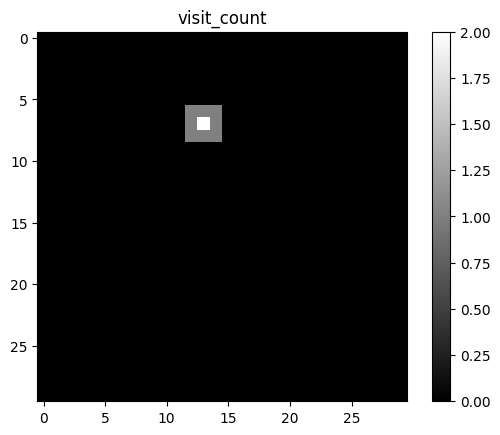

-------------------Time step: 1------------------------


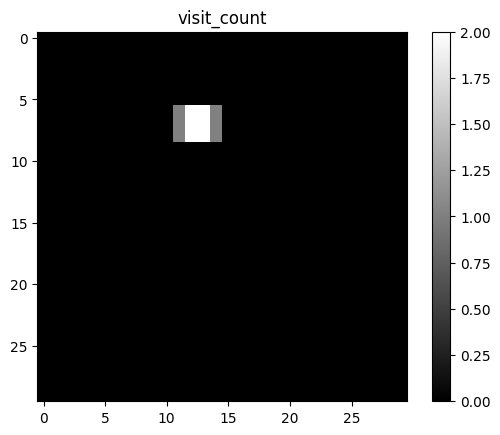

-------------------Time step: 2------------------------


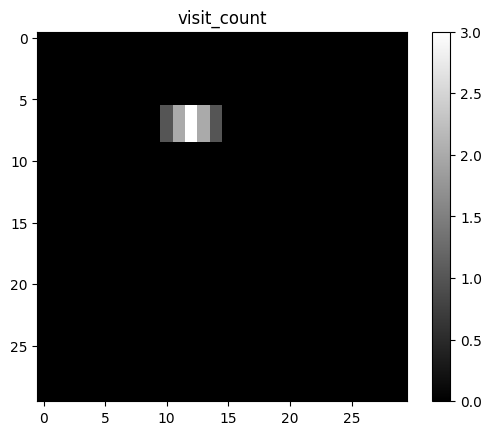

-------------------Time step: 3------------------------


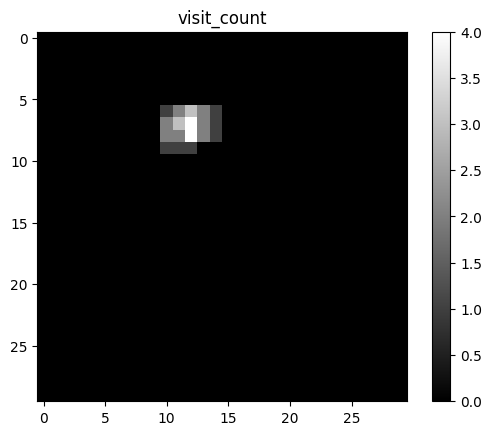


********************Episode: 2/4********************
-------------------Time step: 0------------------------


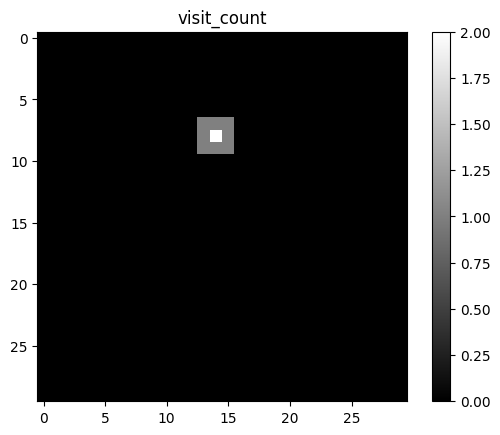

-------------------Time step: 1------------------------


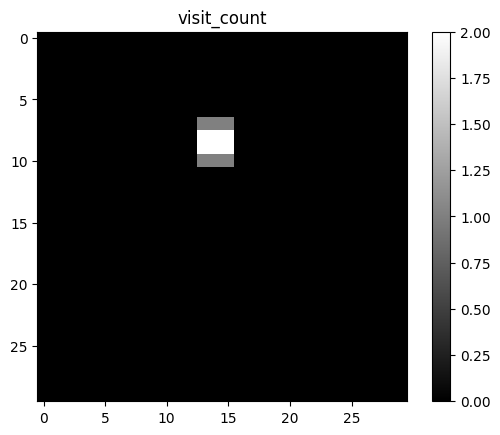

-------------------Time step: 2------------------------


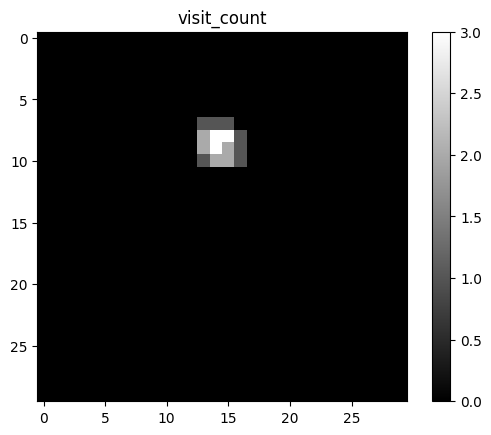

-------------------Time step: 3------------------------


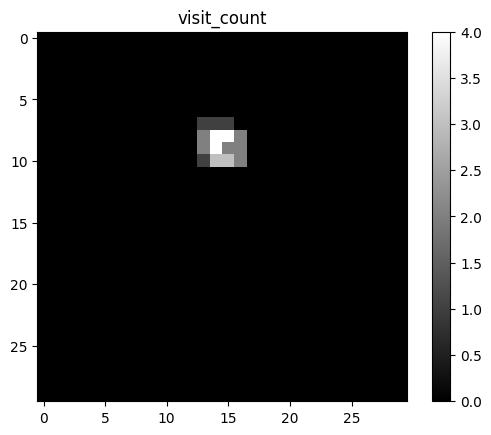


********************Episode: 3/4********************
-------------------Time step: 0------------------------


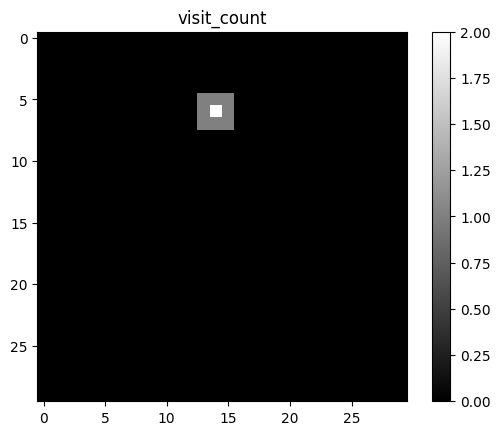

-------------------Time step: 1------------------------


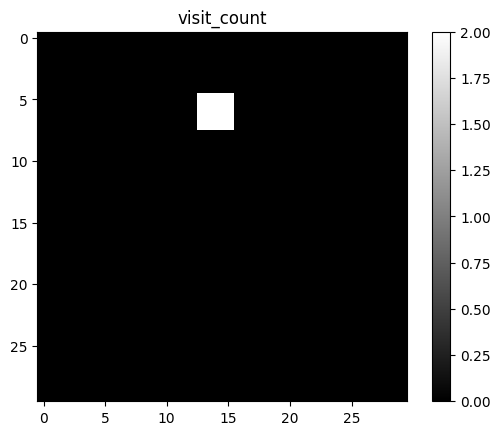

-------------------Time step: 2------------------------


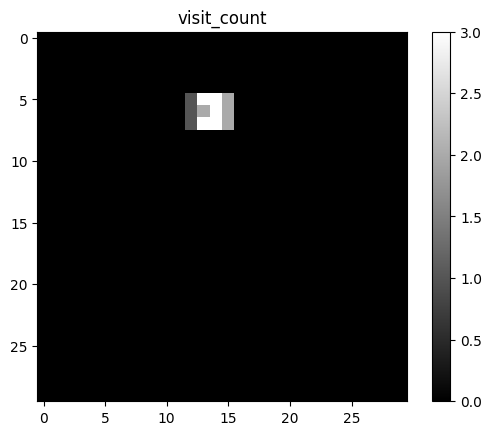

Start training DQN model with batch size: 10
1/1 [==============================] - 0s 72ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 1s 981ms/step - loss: 0.0658
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 1.3207
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.8993
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.5270


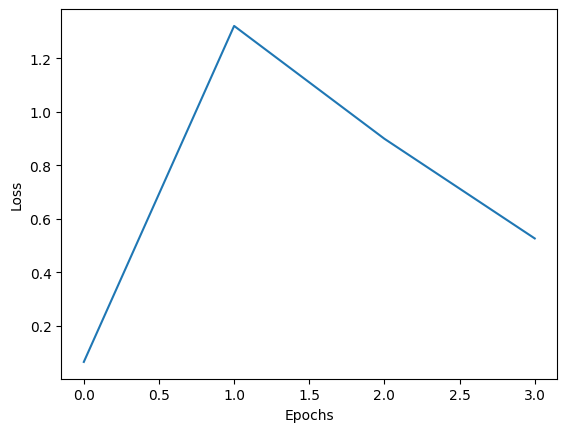

1/1 [==============================] - 0s 15ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.3355
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.2731
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.2371
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1437


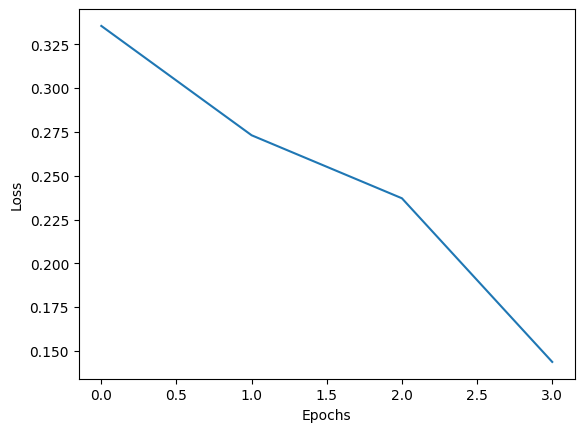

1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0236
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0113
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0079


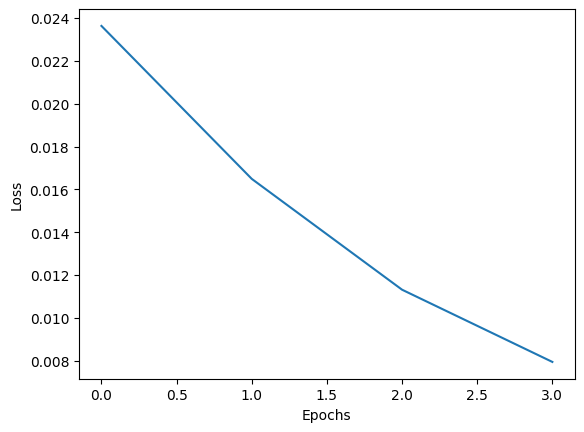

1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0500
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1039
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0234
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0353


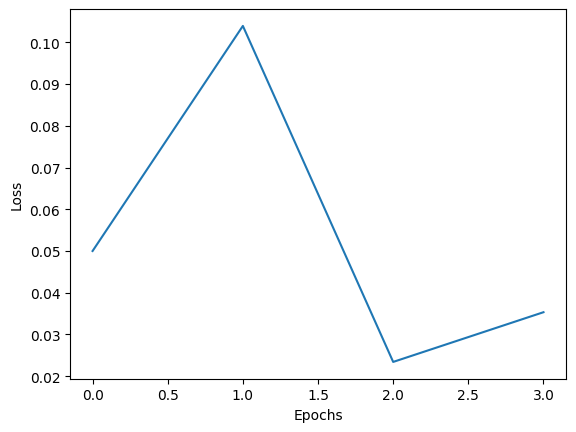

1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0039
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0031
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0035


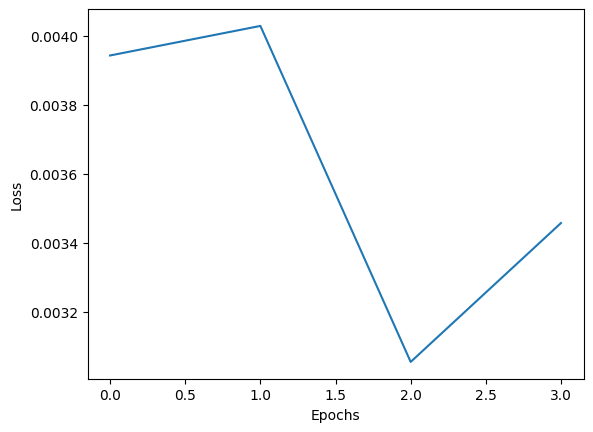

1/1 [==============================] - 0s 15ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1140
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1012
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0560
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0332


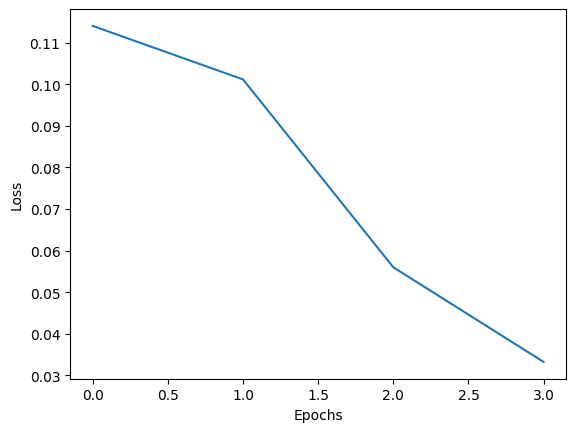

1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1207
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1143
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0250
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1247


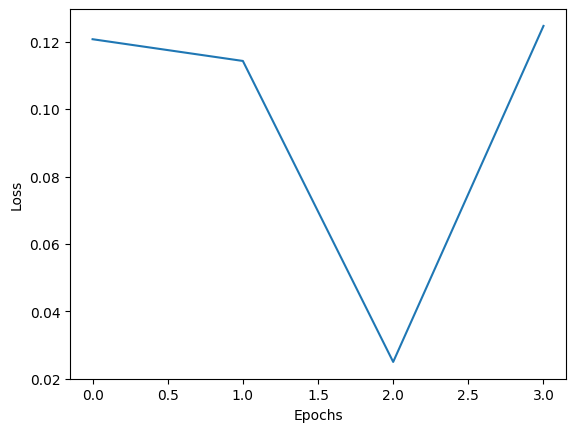

1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0255
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0090


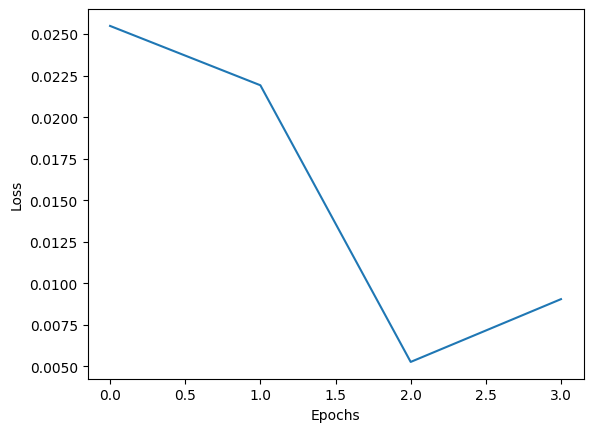

1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1061
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0945
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0793
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0547


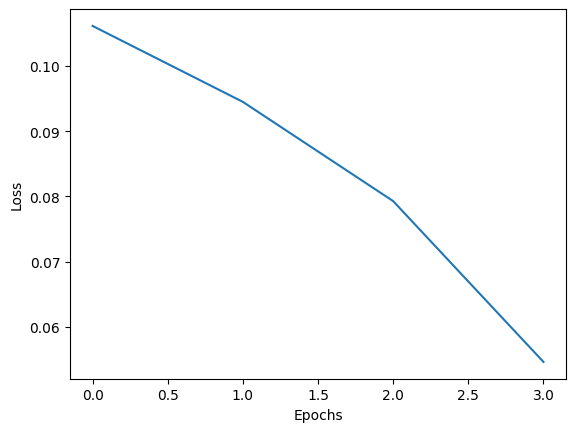

1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0052


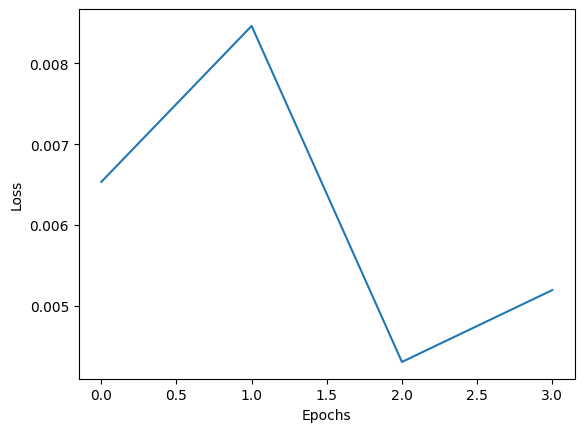

-------------------Time step: 3------------------------


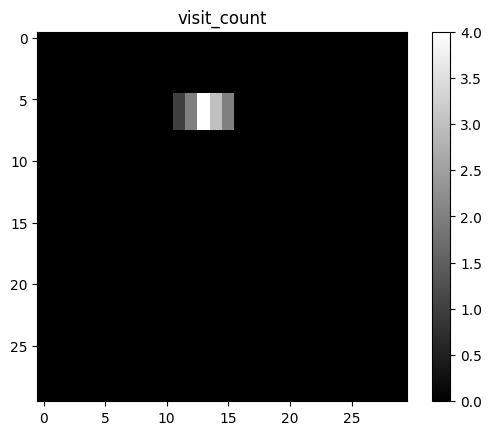

Start training DQN model with batch size: 10
1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1846
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1698
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0604
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0212


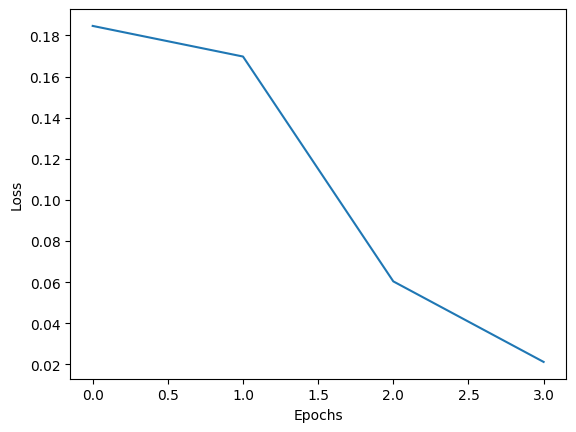

1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1604
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0640
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0145


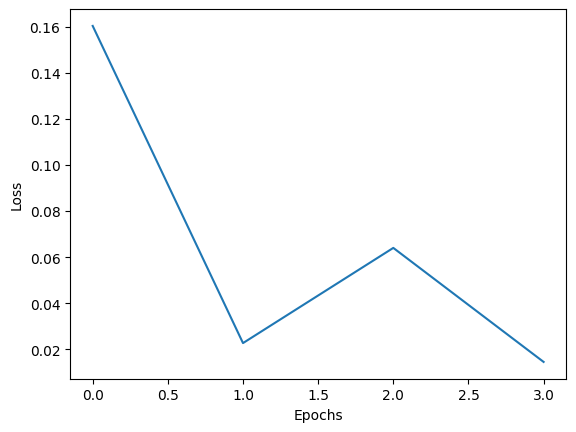

1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1663
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0835
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0142
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1441


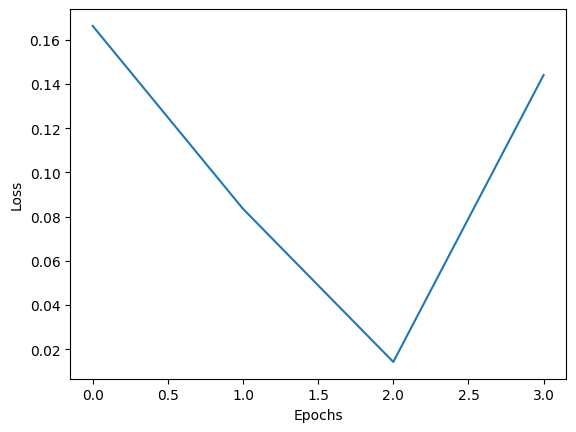

1/1 [==============================] - 0s 16ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1630
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1273
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0727
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0484


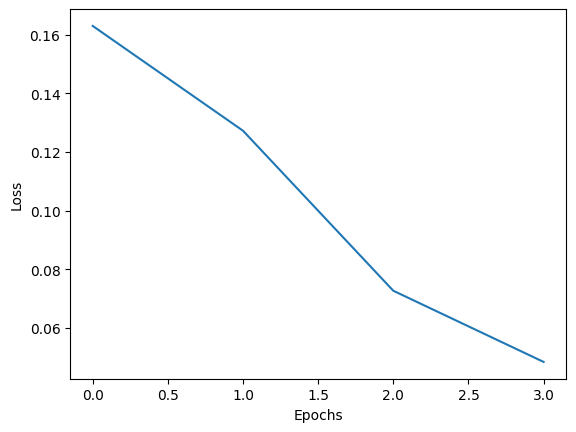

1/1 [==============================] - 0s 14ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0691
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0500
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0160


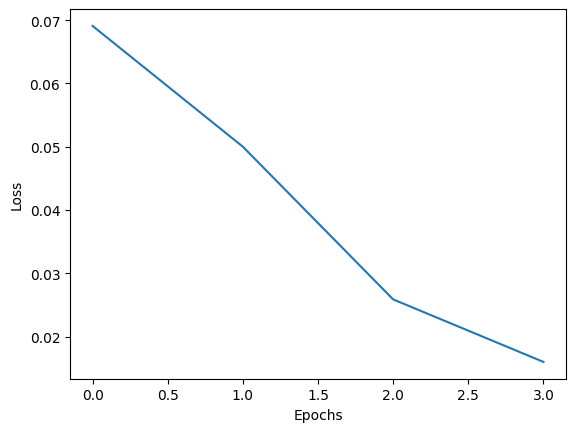

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0097
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0112


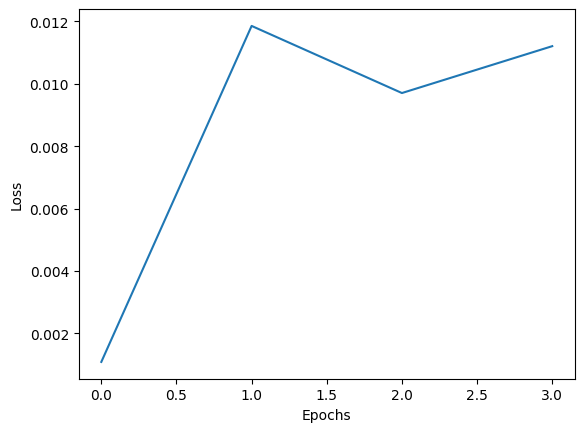

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0387
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0356
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0236


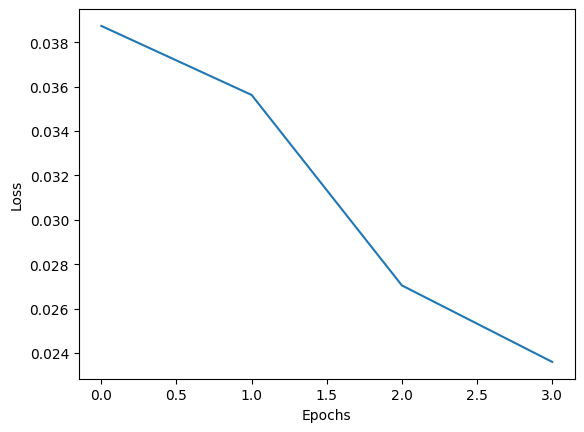

1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0847
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0794
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0579
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0349


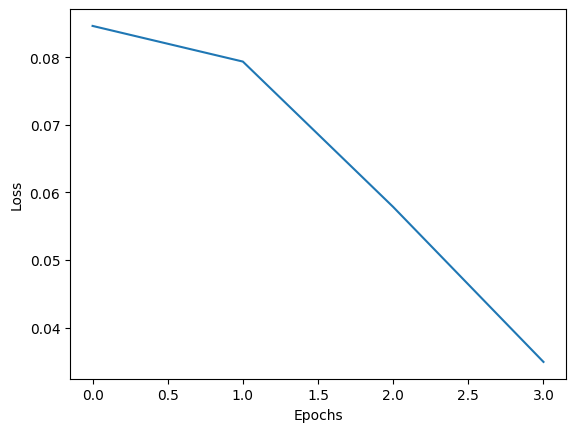

1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0043


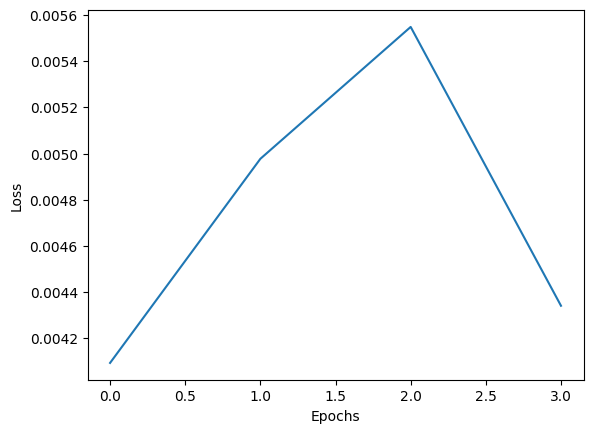

1/1 [==============================] - 0s 15ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.3144
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.2040
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0552
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0231


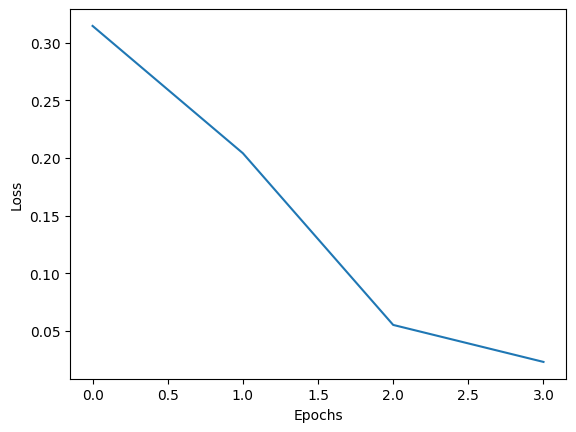


********************Episode: 4/4********************
-------------------Time step: 0------------------------


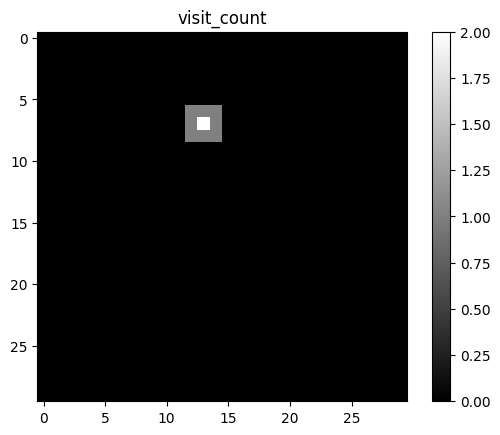

Start training DQN model with batch size: 10
1/1 [==============================] - 0s 17ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.2483
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.2395
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0396
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1006


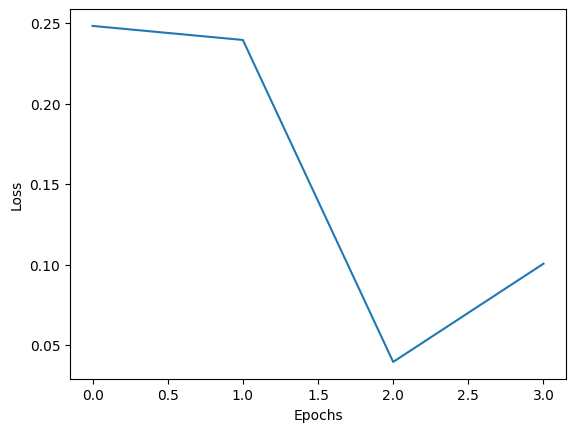

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0184
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0218
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0186


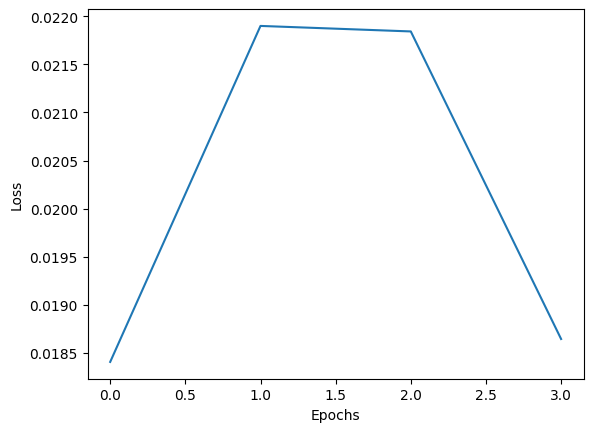

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0254
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0179
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0136
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0069


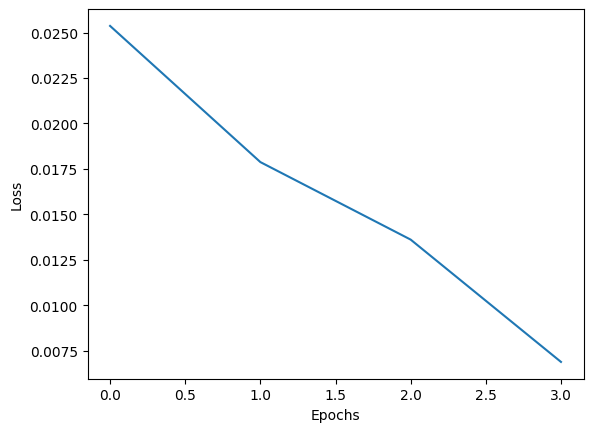

1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0035
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0036
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0034


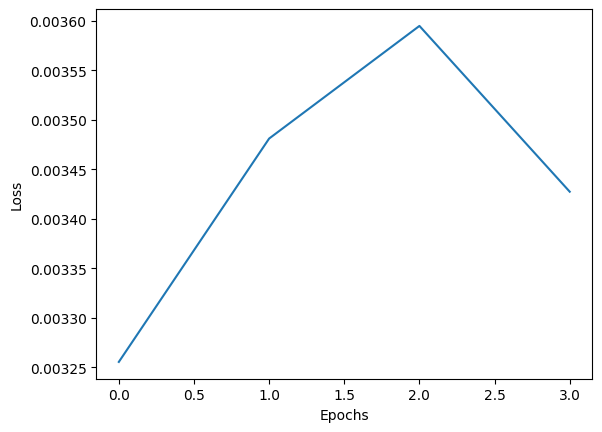

1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0707
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0554
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0235
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0431


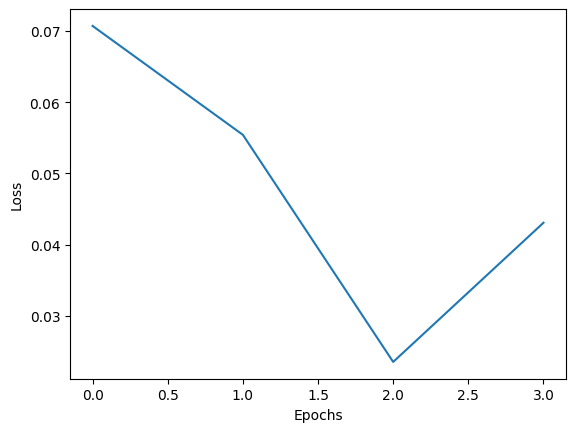

1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0020


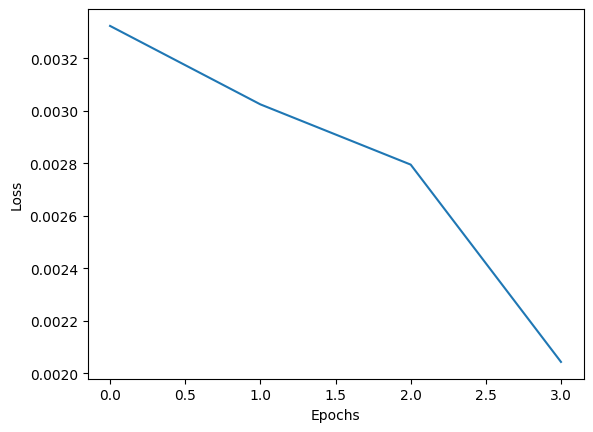

1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0343
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0120
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0046


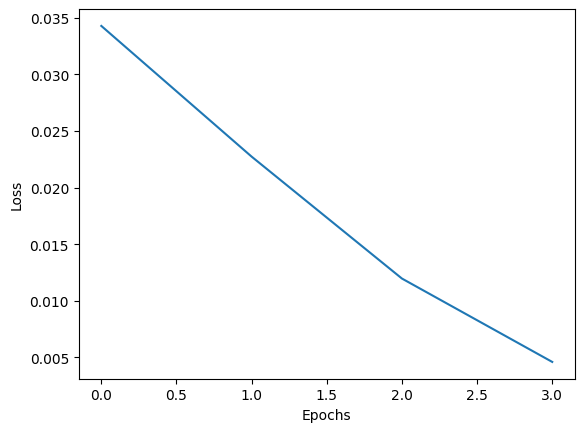

1/1 [==============================] - 0s 17ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0159
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0166
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0147
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0118


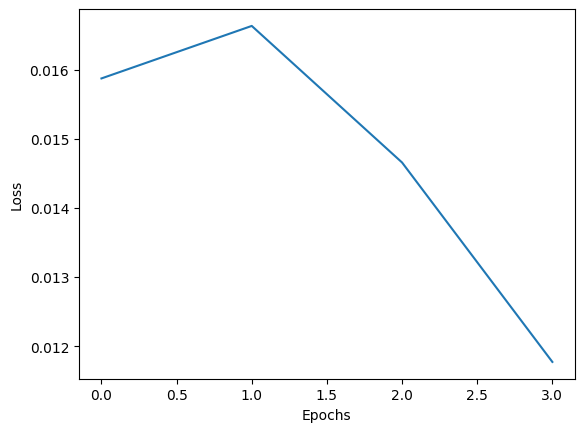

1/1 [==============================] - 0s 16ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.3054
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1595
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1408
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0936


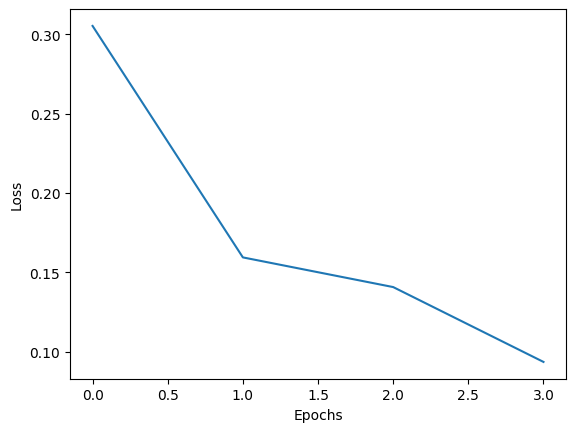

1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 8ms/step - loss: 0.3053
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1999
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1371
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1115


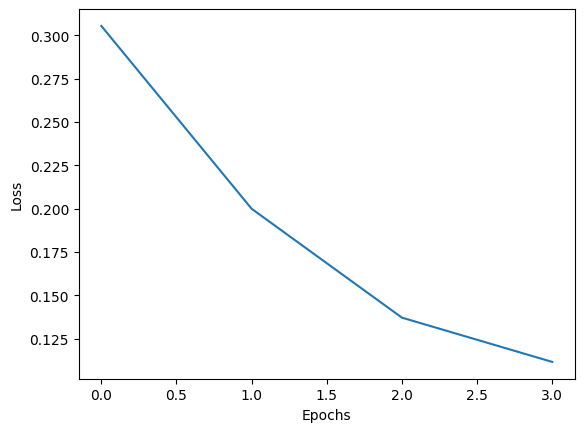

-------------------Time step: 1------------------------


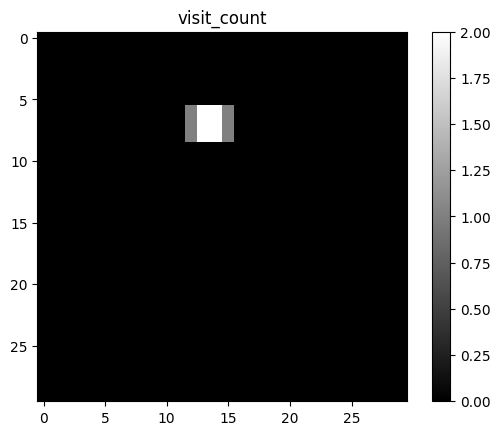

Start training DQN model with batch size: 10
1/1 [==============================] - 0s 16ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 3/4
1/1 [==============================] - 0s 9ms/step - loss: 0.0028
Epoch 4/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0018


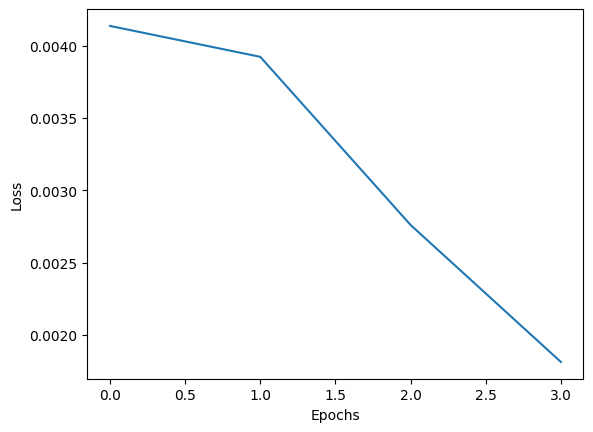

1/1 [==============================] - 0s 14ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1480
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0983
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0750
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0611


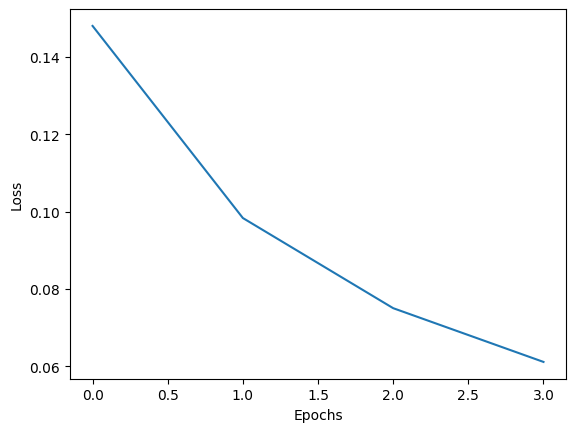

1/1 [==============================] - 0s 14ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0683
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0681
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0609
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0465


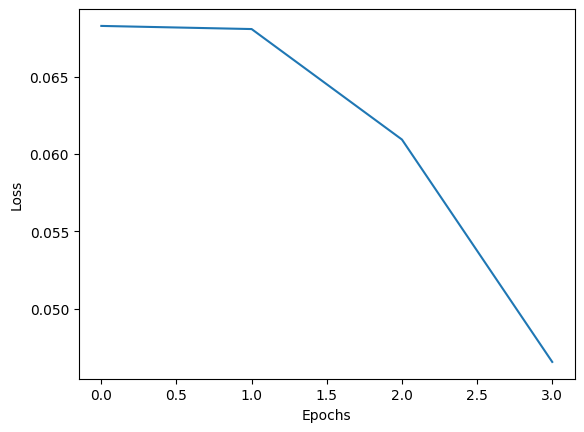

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0109
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0071
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0047


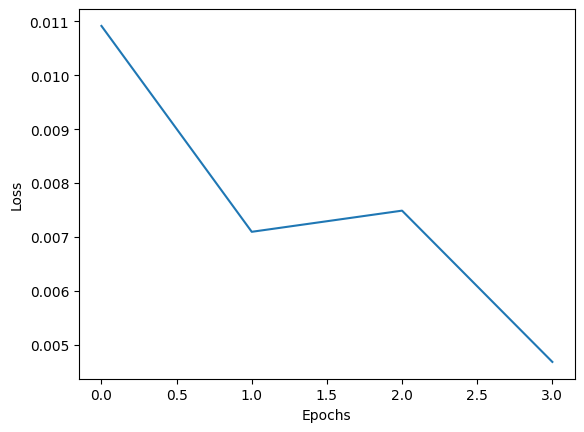

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0347
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0314
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0234


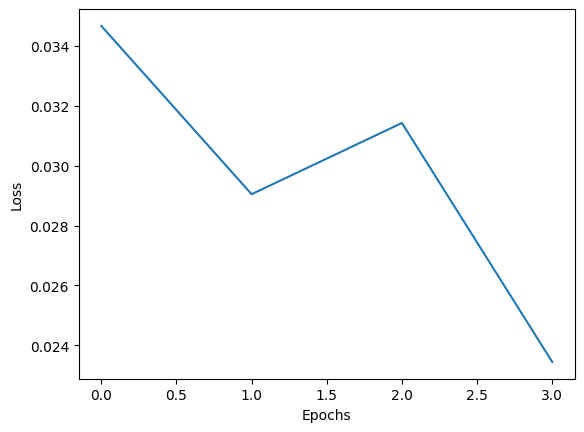

1/1 [==============================] - 0s 22ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.2102
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1047
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0047
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0173


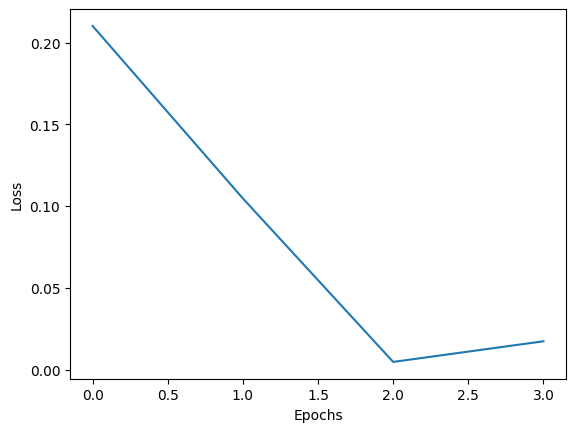

1/1 [==============================] - 0s 17ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0117
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0069
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0051


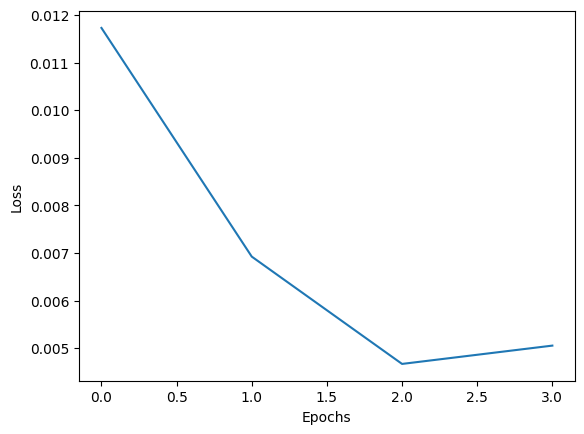

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1076
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0678
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0541
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0584


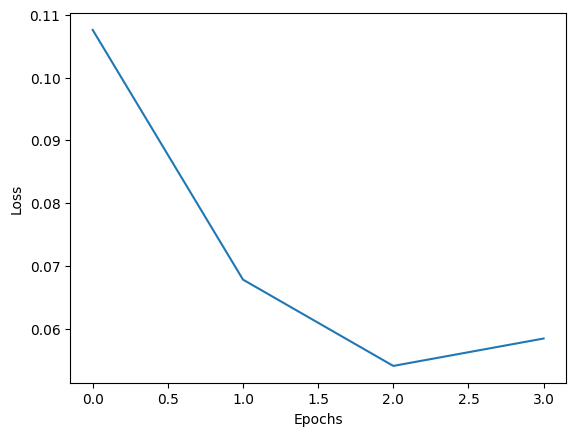

1/1 [==============================] - 0s 17ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0039
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0052


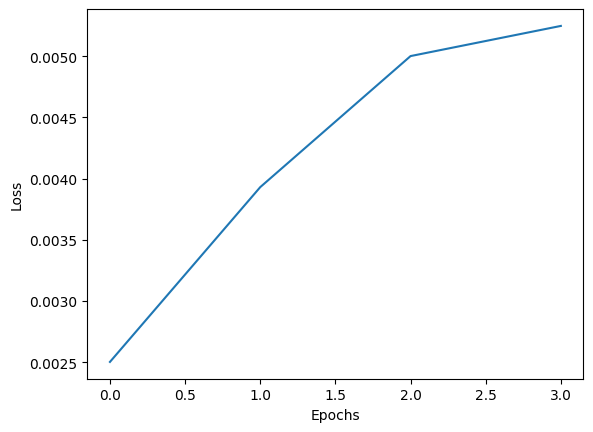

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0111
Epoch 2/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0141
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0085
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0117


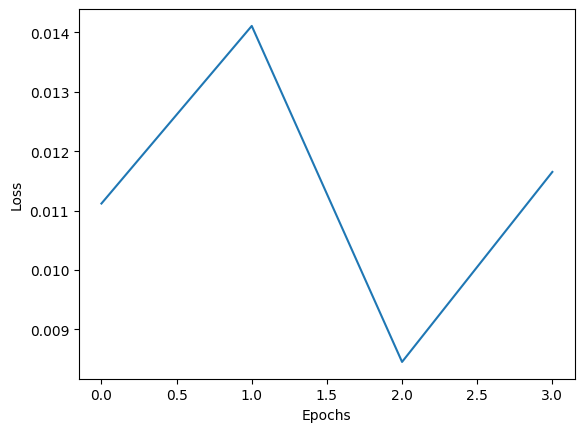

-------------------Time step: 2------------------------


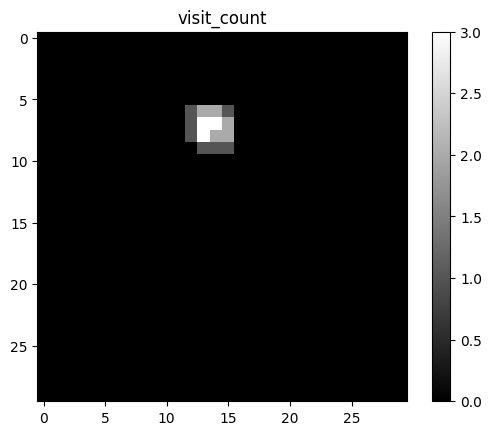

Start training DQN model with batch size: 10
1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0133
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0166
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0090


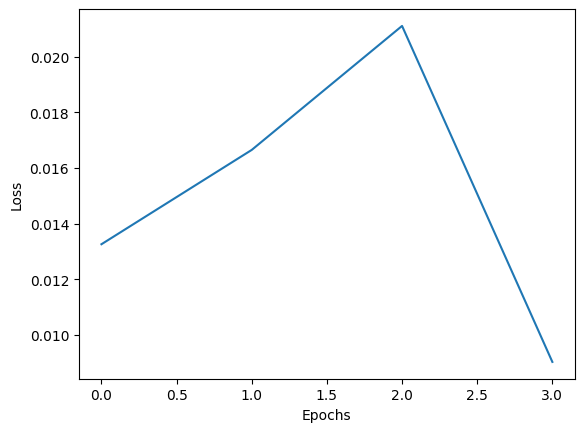

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0104
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0079


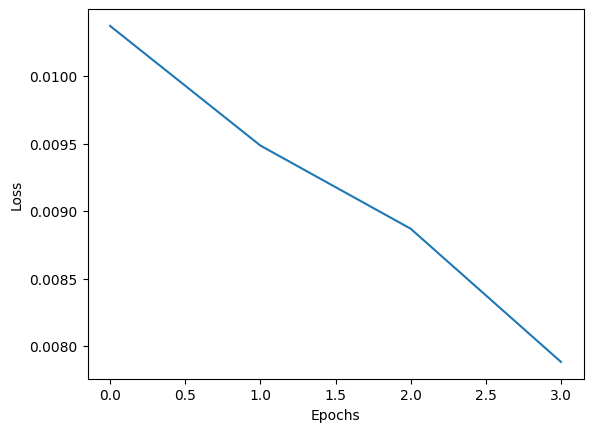

1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0239
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0129
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0014


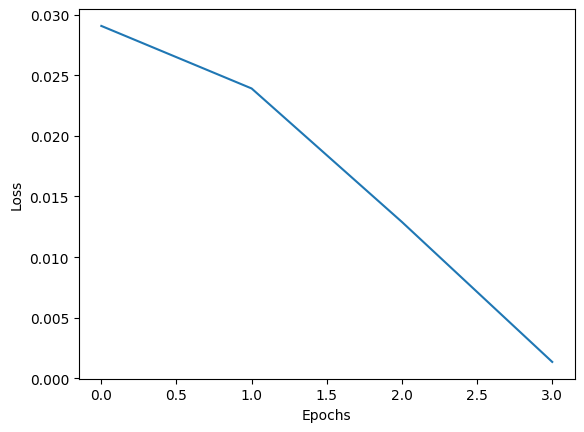

1/1 [==============================] - 0s 17ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0018


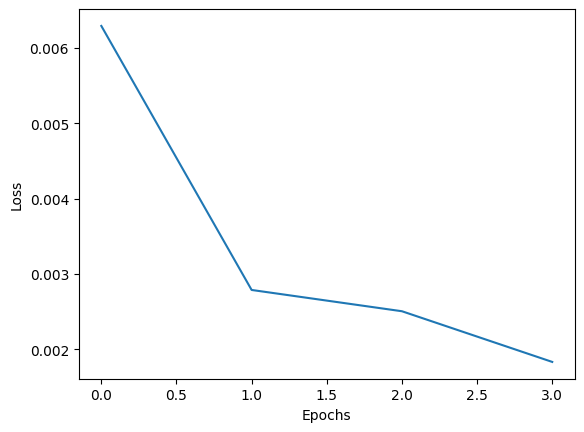

1/1 [==============================] - 0s 15ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 9ms/step - loss: 0.0072
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0020


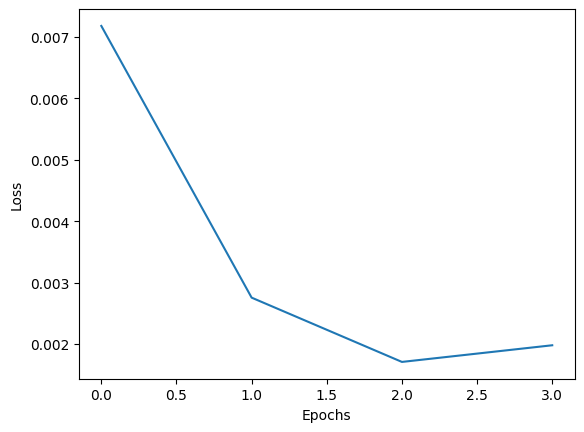

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0423
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0292
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 4/4
1/1 [==============================] - 0s 10ms/step - loss: 0.0135


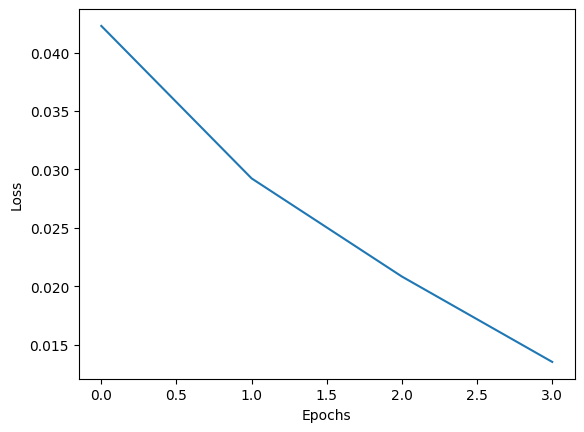

1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0035


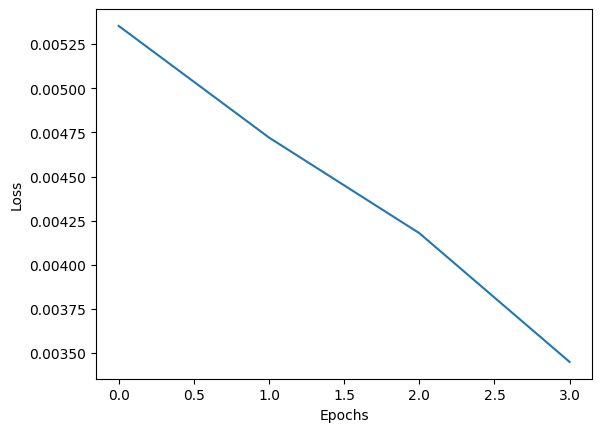

1/1 [==============================] - 0s 15ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1426
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1383
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1275
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1137


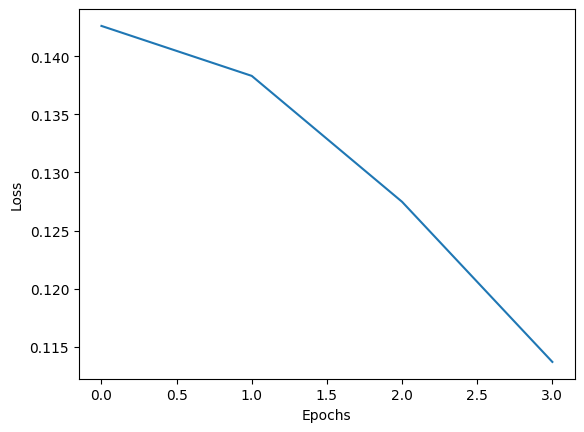

1/1 [==============================] - 0s 15ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0110
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0118
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0126
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0071


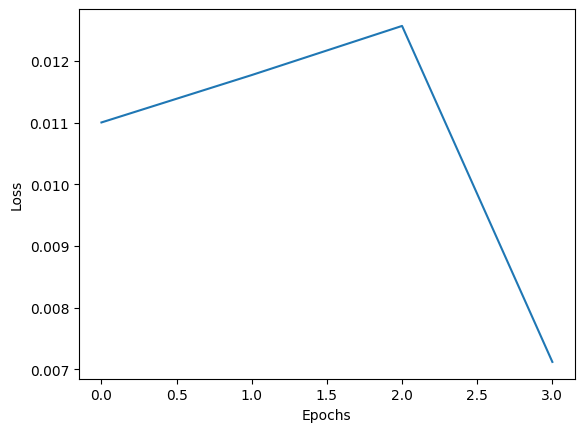

1/1 [==============================] - 0s 18ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0074
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0080
Epoch 3/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0054
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0073


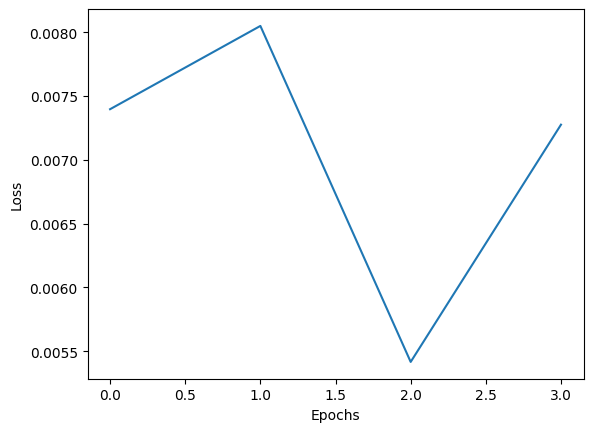

-------------------Time step: 3------------------------


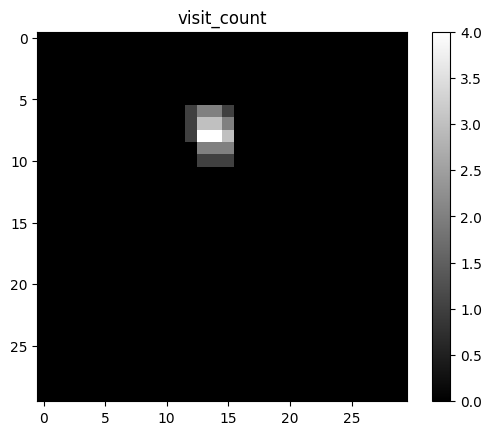

Start training DQN model with batch size: 10
1/1 [==============================] - 0s 17ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0017
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0014


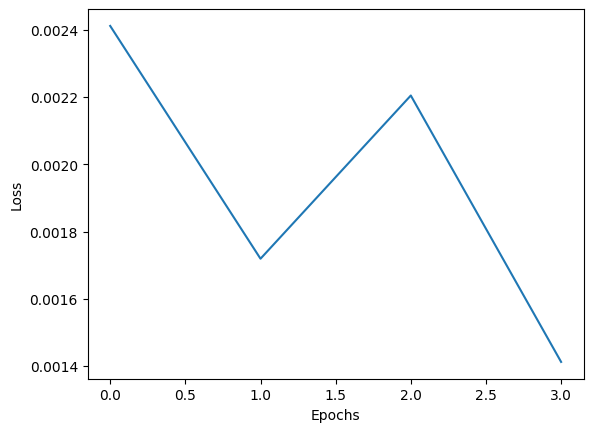

1/1 [==============================] - 0s 16ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0092
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0083
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0072


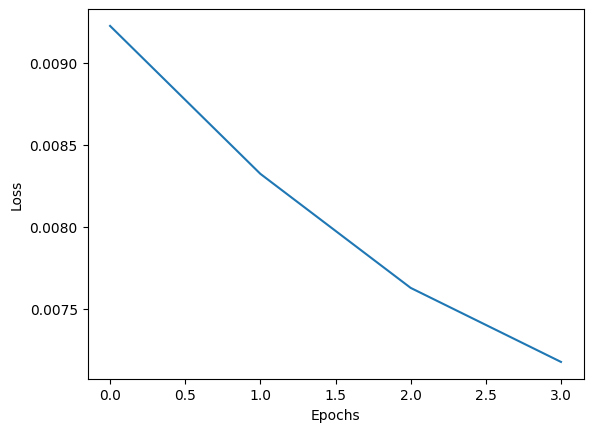

1/1 [==============================] - 0s 14ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0233
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0143
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0082


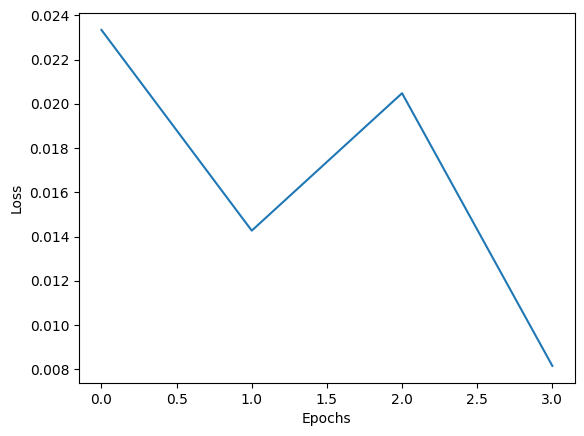

1/1 [==============================] - 0s 16ms/step
Ready to take action:0
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1628
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1405
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.1218
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.1048


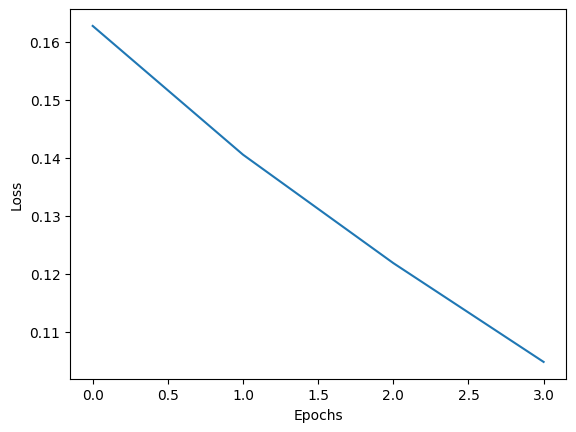

1/1 [==============================] - 0s 15ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0061


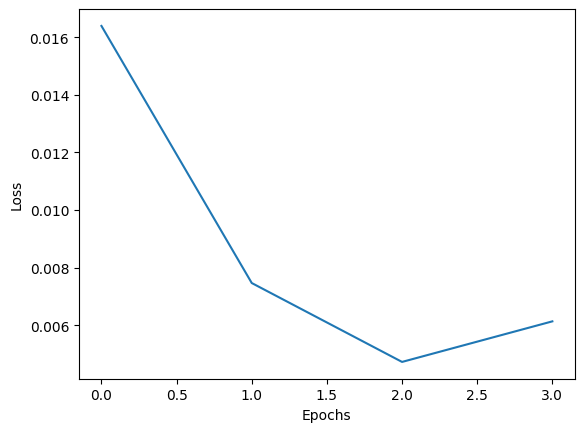

1/1 [==============================] - 0s 14ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0057
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0040


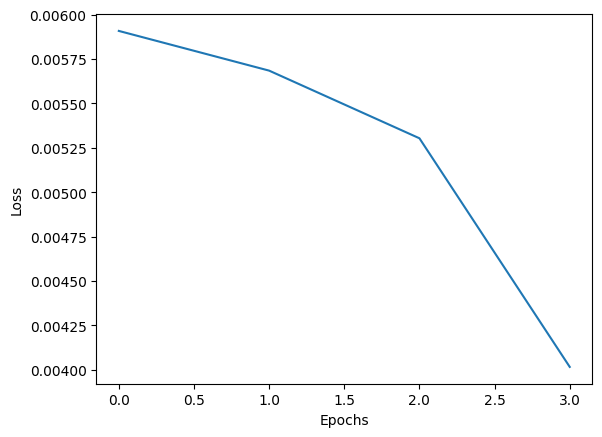

1/1 [==============================] - 0s 15ms/step
Ready to take action:3
Epoch 1/4
1/1 [==============================] - 0s 8ms/step - loss: 0.0768
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0484
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0140
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0120


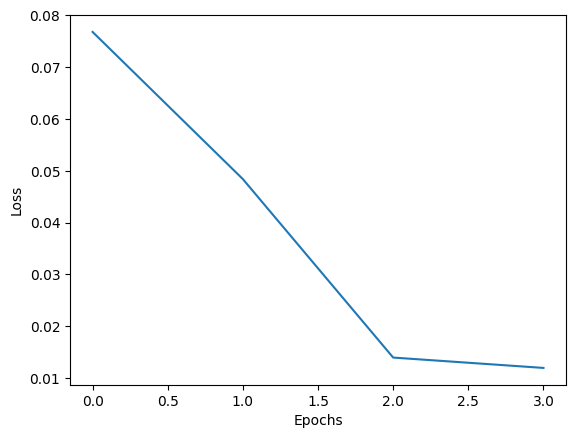

1/1 [==============================] - 0s 14ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 2/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0070
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 4/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0011


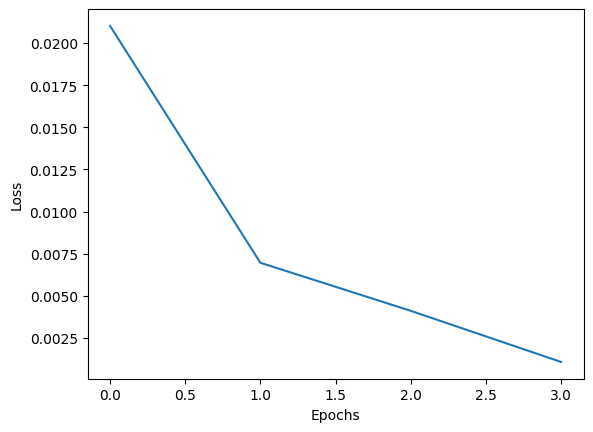

1/1 [==============================] - 0s 16ms/step
Ready to take action:2
Epoch 1/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 2/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0050
Epoch 3/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0033


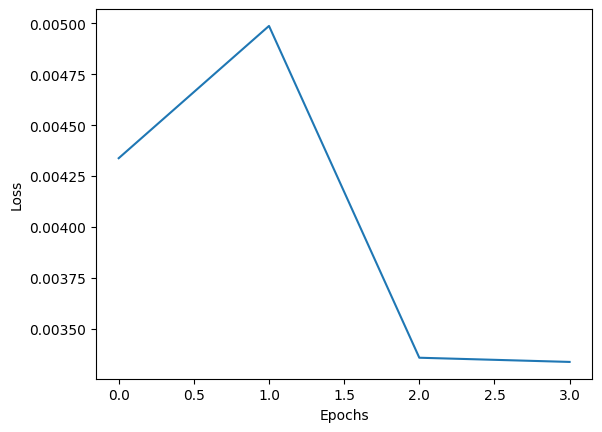

1/1 [==============================] - 0s 16ms/step
Ready to take action:1
Epoch 1/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0138
Epoch 2/4
1/1 [==============================] - 0s 7ms/step - loss: 0.0124
Epoch 3/4
1/1 [==============================] - 0s 5ms/step - loss: 0.0164
Epoch 4/4
1/1 [==============================] - 0s 6ms/step - loss: 0.0123


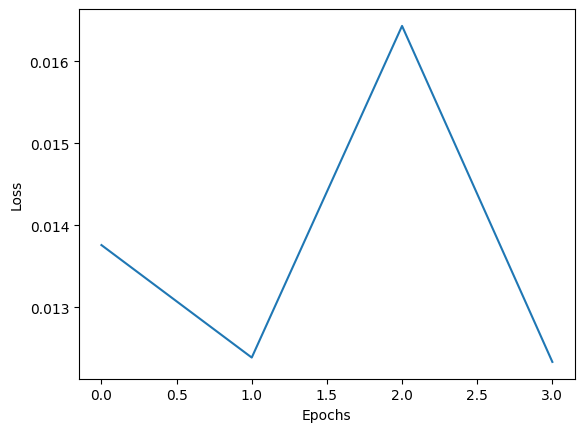

In [7]:
# Track rewards for plotting
rewards_list = []
time_step_rewards = []

for episode in range(n_episodes): # 训练多少张图
    print(f"\n********************Episode: {episode+1}/{n_episodes}********************")
    state = env.reset()
    # print(np.array(state[0]).shape)
    state,_ = prepare_state(state)
    # state = np.reshape(state, [1, *state.shape])
    total_reward = 0
    time_step_rewards.append(total_reward)
    
    for time_step in range(time_steps):  # 每张图训练小车走至多多少步
        print(f"-------------------Time step: {time_step}------------------------")
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        env.render(map_type="visit_count")
        next_state,_ = prepare_state(next_state)
        # next_state = np.reshape(next_state, [1, *state_size])
        
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        time_step_rewards.append(total_reward)

        if done:
            print(f"Episode: {episode+1}/{n_episodes}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")
            break

        if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
            print(f"Start training DQN model with batch size: {batch_size}")
            losses = train_dqn(batch_size)
            # plt.plot(losses)
            # plt.xlabel('Epoch')
            # plt.ylabel('Loss')
            # plt.show()
            # print(f"Training DQN model with batch size: {batch_size}")
    
    rewards_list.append(total_reward)
    
    # Decay epsilon after each episode
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay